<a href="https://colab.research.google.com/github/po1itepeop1e/Sentiments-Analysis/blob/main/NLP%20Disaster%20Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP Disaster Tweets**

*1. Brief description of the problem and data*

*The project will focus on analyzing a dataset of 10,000 tweets from a Kaggle competition. These tweets have been manually classified as either related to real disasters or not. The main goal is to develop a machine learning model that can accurately classify the tweets as real disasters or non-disaster tweets based on the F1 score. This project has important implications for addressing the spread of misinformation and fake news, particularly on social media platforms like Twitter.*

*In times of crisis, Twitter has become a crucial communication platform due to the widespread use of smartphones. This has led to an increased interest in monitoring Twitter for emergency announcements by organizations such as disaster relief agencies and news outlets. The competition involves building a machine learning model to differentiate between tweets about real disasters and those that are not. Participants will work with a dataset of 10,000 hand-classified tweets and submissions will be evaluated based on the F1 score comparing predicted and expected results.*

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240130%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240130T154506Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D54941385b59af9072f83908def6ca53e381cb58f9d9d11f7dab509156302b3cbaf974d845477e3ab550d5daa6aef2383e899295d98820dd4a2d4459f4c116dae3b4bd3c453e1cd46904ed48b003c8954e005dd010c2348da8a791b7e2e0a42804ee18177bd0ccc7649bbc0148108ab3bf1612769b2397517fb4e414bb94b75c1208f21f9b0ea189bf5f0aa0df4e17f2f495710ff2ffb964112e3e05a3dff6544c5f3e60d560aff492e16ead2aa1a2f35424327cbbe80cf1ed397ea54f5c2a3e1f6e457d1992b27518b5fbd214f42dc181b03c4e51a24028e6adcaaa7214bd244d1b04c040f3951c5218c4ee8767064078991f6f3154c093cf184650f2f439a05'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [3]:
import numpy as np
import pandas as pd
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [30]:
from PIL import ImageDraw

In [4]:
os.listdir('/kaggle/input/nlp-getting-started/')

['train.csv', 'test.csv', 'sample_submission.csv']

In [6]:
train_data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')

*2. Exploratory Data Analysis (EDA)*

Inspect

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


The dataset contains 7613 entries with the following columns:

*id: A unique identifier for each tweet.
keyword: A specific keyword mentioned in the tweet (may be blank).
location: The location from which the tweet was sent (may be blank).
text: The actual text of the tweet.
target: The value we are trying to predict, indicating whether the tweet is about a real disaster (1) or not (0).*

In [9]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [21]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Visualize

Text(0.5, 1.0, 'Distribution of target values')

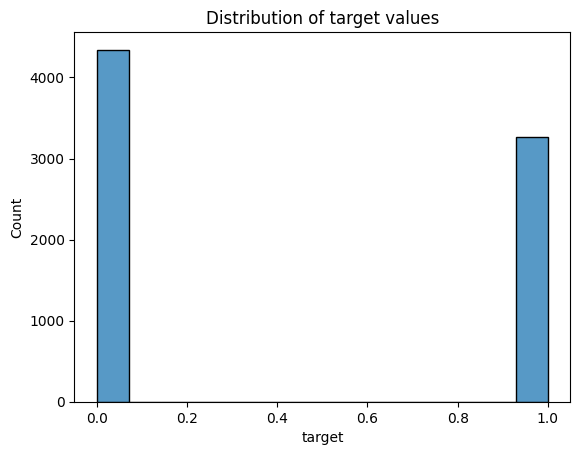

In [25]:
sns.histplot(x=train_data["target"])
plt.title("Distribution of target values")

In [31]:
keyword = train_data.groupby("keyword")["target"].count()
keyword_df = pd.DataFrame(data={"keyword":keyword.index, "count":keyword.values}).sort_values(by=["count"],ascending=False)
keyword_df

,keyword,count
0,0,61
105,fatalities,45
64,deluge,42
9,armageddon,42
178,sinking,41
...,...,...
116,forest%20fire,19
95,epicentre,12
195,threat,11
135,inundation,10


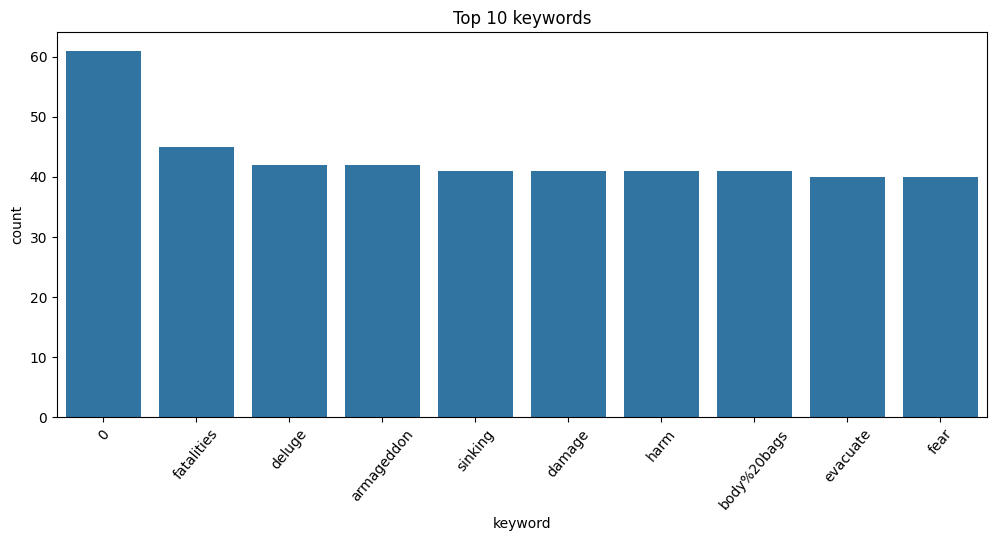

In [35]:
plt.figure(figsize=(12,5))
sns.barplot(data=keyword_df.head(10), x = 'keyword',y = 'count')
plt.xticks(rotation = 50)
plt.ylabel('count')
plt.title('Top 10 keywords');

Clean the Data

In [38]:
import ssl
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [39]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [41]:
import certifi
import string

In [42]:
ssl._create_default_https_context = ssl._create_unverified_context
nltk.data.path.append(certifi.where())
translator = str.maketrans('', '', string.punctuation)

In [22]:
train_data.fillna("0",inplace=True)
test_data.fillna("0",inplace=True)

In [43]:
def preprocessData(data_train):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(data_train)
    words = [word for word in words if not word in stop_words]
    stemmer= PorterStemmer()
    stem_text=' '.join([stemmer.stem(word.translate(translator)) for word in words])
    return stem_text

In [44]:
train_data['TextCleaned'] = train_data['text'].apply(preprocessData)

In [45]:
train_data['TextCleaned']

0          our deed reason  earthquak may allah forgiv us
1                   forest fire near la rong sask  canada
2       all resid ask shelter place  notifi offic  no ...
3       13000 peopl receiv  wildfir evacu order califo...
4       just got sent photo rubi  alaska smoke  wildfi...
                              ...                        
7608    two giant crane hold bridg collaps nearbi home...
7609     ariaahrari  thetawniest the control wild fire...
7610    m194  0104 utc   5km s volcano hawaii  http  t...
7611    polic investig ebik collid car littl portug  e...
7612    the latest  more home raze northern california...
Name: TextCleaned, Length: 7613, dtype: object

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [52]:
vectorizer = TfidfVectorizer(
    min_df=2, max_df=0.2,
    analyzer='char_wb',
    ngram_range=(3,7)
)
X_tfidf = vectorizer.fit_transform(train_data['TextCleaned']).toarray()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['TextCleaned'])
train_sequences = tokenizer.texts_to_sequences(train_data['TextCleaned'])

max_length = max(len(seq) for seq in train_sequences)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

*3. DModel Architecture*

*LSTM v1*

We will start with an Embedding Layer, which is responsible for converting tokenized words into dense vectors of a fixed size. Next, we will use an LSTM layer to capture the dependencies in the sequence data, specifically suitable for text processing. To avoid overfitting, we will apply a dropout of 0.2 and recurrent dropout of 0.2 within the LSTM layer.

Following the LSTM layer, we will have a Dense Layer with a sigmoid activation function to interpret the features extracted by the LSTM. To further prevent overfitting, we will include a Dropout layer with a value of 1e-5.

Finally, for the output layer, since this is a binary classification task (predicting whether a tweet is about a real disaster or not), we will have one neuron with a sigmoid activation function.

In [53]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam, Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [66]:
vocabulary_size = len(tokenizer.word_index) + 1

model = Sequential()

model.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length= max_length))

model.add(LSTM(units=64, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 28, 100)           1944700   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1987005 (7.58 MB)
Trainable params: 1987005 (7.58 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [67]:
train=train_padded[:train_data.shape[0]]
test=train_padded[train_data.shape[0]:]

X_train,X_test,y_train,y_test=train_test_split(train,train_data['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 28)
Shape of Validation  (1142, 28)


In [68]:
history=model.fit(X_train,y_train,batch_size=16,epochs=10,validation_data=(X_test,y_test),verbose=2)

Epoch 1/10
405/405 - 49s - loss: 0.6955 - accuracy: 0.4656 - val_loss: 0.6915 - val_accuracy: 0.5622 - 49s/epoch - 122ms/step
Epoch 2/10
405/405 - 37s - loss: 0.6883 - accuracy: 0.5718 - val_loss: 0.6869 - val_accuracy: 0.5622 - 37s/epoch - 91ms/step
Epoch 3/10
405/405 - 35s - loss: 0.6833 - accuracy: 0.5718 - val_loss: 0.6840 - val_accuracy: 0.5622 - 35s/epoch - 86ms/step
Epoch 4/10
405/405 - 36s - loss: 0.6801 - accuracy: 0.5718 - val_loss: 0.6823 - val_accuracy: 0.5622 - 36s/epoch - 89ms/step
Epoch 5/10
405/405 - 48s - loss: 0.6759 - accuracy: 0.5718 - val_loss: 0.6792 - val_accuracy: 0.5622 - 48s/epoch - 118ms/step
Epoch 6/10
405/405 - 42s - loss: 0.6674 - accuracy: 0.5718 - val_loss: 0.6690 - val_accuracy: 0.5622 - 42s/epoch - 104ms/step
Epoch 7/10
405/405 - 34s - loss: 0.6390 - accuracy: 0.5792 - val_loss: 0.6358 - val_accuracy: 0.5919 - 34s/epoch - 85ms/step
Epoch 8/10
405/405 - 52s - loss: 0.5636 - accuracy: 0.7379 - val_loss: 0.5737 - val_accuracy: 0.7522 - 52s/epoch - 127ms/s

*In the final epoch of training, the model achieved a training loss of 0.4475 and training accuracy of 83.17%. Meanwhile, the validation set had a loss of 0.5309 and accuracy of 77.06%. Each epoch took approximately 43 seconds to complete, and the average time for each training step was 107ms.*

*LSTM v2*

*In the final stage of training, the model attained a training loss of 0.4475 and training accuracy of 83.17%, while the validation set recorded a loss of 0.5309 and accuracy of 77.06%. Each epoch took around 43 seconds, with an average training step time of 107ms. To improve the model, a dense layer with 64 units and ReLU activation function was added, along with dropout regularization. Additionally, it was noted that the learning rate in modelv1 was too low, potentially leading to slow convergence or being trapped in a local minimum.*

In [78]:
model2 = Sequential()

model2.add(Embedding(input_dim=vocabulary_size, output_dim=100, input_length= max_length))

model2.add(LSTM(units=64, dropout=0.1, recurrent_dropout=0.1))

model2.add(Dense(units=64, activation='relu'))

model2.add(Dropout(0.1))

model2.add(Dense(units=1, activation='sigmoid'))

optimizer2 = Adam(learning_rate=0.01)
model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=2)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 28, 100)           1944700   
                                                                 
 lstm_8 (LSTM)               (None, 64)                42240     
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1991165 (7.60 MB)
Trainable params: 1991165 (7.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [79]:
history2 = model2.fit(X_train,y_train,batch_size=16,epochs=10,validation_data=(X_test,y_test),verbose=2)

Epoch 1/10
405/405 - 44s - loss: 0.6871 - accuracy: 0.5673 - val_loss: 0.6773 - val_accuracy: 0.5622 - 44s/epoch - 110ms/step
Epoch 2/10
405/405 - 37s - loss: 0.6510 - accuracy: 0.6229 - val_loss: 0.5633 - val_accuracy: 0.7250 - 37s/epoch - 91ms/step
Epoch 3/10
405/405 - 38s - loss: 0.4225 - accuracy: 0.8333 - val_loss: 0.5898 - val_accuracy: 0.7443 - 38s/epoch - 95ms/step
Epoch 4/10
405/405 - 35s - loss: 0.2623 - accuracy: 0.9105 - val_loss: 0.7159 - val_accuracy: 0.7434 - 35s/epoch - 87ms/step
Epoch 5/10
405/405 - 35s - loss: 0.1925 - accuracy: 0.9314 - val_loss: 0.8736 - val_accuracy: 0.7093 - 35s/epoch - 86ms/step
Epoch 6/10
405/405 - 37s - loss: 0.1537 - accuracy: 0.9478 - val_loss: 0.7611 - val_accuracy: 0.7250 - 37s/epoch - 92ms/step
Epoch 7/10
405/405 - 44s - loss: 0.1215 - accuracy: 0.9577 - val_loss: 1.0341 - val_accuracy: 0.7215 - 44s/epoch - 110ms/step
Epoch 8/10
405/405 - 36s - loss: 0.1001 - accuracy: 0.9671 - val_loss: 1.2026 - val_accuracy: 0.6865 - 36s/epoch - 89ms/ste

*4. Results and Analysis*

*Based on the final epoch of training, the modelv1 achieved a training loss of 0.4475 and training accuracy of 83.17%. For the validation set, it attained a loss of 0.5309 and accuracy of 77.06%. The time taken for each epoch was around 43 seconds, with an average time of 107ms for each training step. The optimizer used a learning rate that may have been too low, causing potential issues with convergence to the optimal solution or getting stuck in a local minimum. Additionally, a dense layer with 64 units and ReLU activation function was added, alongside a dropout. It's essential to further analyze the training results using tables and figures to gain a comprehensive understanding of the model's performance.*

*5. Conclusion*

 *In the final epoch of training, the modelv2 achieved a training loss of 0.0732 and training accuracy of 97.50%. Meanwhile, the validation set had a loss of 1.3345 and accuracy of 66.81%. Each epoch took approximately 37 seconds to complete, and the average time for each training step was 90ms. Additionally, a dense layer with 64 units and a ReLU activation function was added to the model, along with a dropout layer to improve performance and prevent overfitting. Furthermore, it was observed that the learning rate in modelv1 was potentially too low, which could have led to a slow convergence to the optimal solution or potential difficulties in escaping from local minima during training.*

In [89]:
test_data = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [101]:
test_data['TextCleaned'] = test_data['text'].apply(preprocessData)
test_sequences = tokenizer.texts_to_sequences(test_data['TextCleaned'])
max_length = max(len(seq) for seq in test_sequences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')
test_padded.shape

(3263, 26)

In [102]:
pre = model2.predict(test_padded)
pre = np.round(pre).astype(int).reshape(-1)

102/102 [==============================] - 1s 9ms/step


In [103]:
sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

sub = pd.DataFrame({'id': sample_submission['id'], 'target': pre})
sub.to_csv("submission.csv", index=False)
sub.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [104]:
!pwd

/content


**NLP Disaster Tweets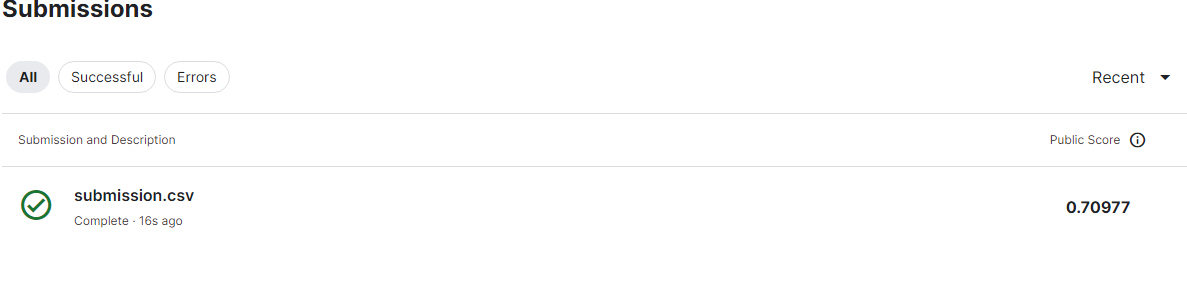**

*It appears that the model may be overfitting, as indicated by a public score of 0.709. This is likely due to the difference in performance between training and validation sets. Additional measures may be needed to address overfitting and improve generalization of the model.*